## tasks
### 1: Form training and testing periods as discussed (2 test periods, last 2*365 days). Be careful tp scale data only based on data from the training set. You may use (from Python) MinMaxScaler, standardisation (StandardScaler) or the default scaler in Python's elastic net.
### 2:Estimate the current flu rates by training an elastic net model. Use a Pearson correlation filter (r > 0.3) on the training data to reduce the amount of queries prior to training an elastic net (reminder: not all 1000 queries I provided are related to flu!). Report performance on the two test sets using three metrics: mean absolute error, root mean squared error and Pearson's correlation.
### 3: If there is time, begin work on traditional forecasting models (you've identified seasonal ARIMA and Hult-Winters).

In [2]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (10, 10)
# histogram size
bin_size = 10

In [3]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [4]:
l =X.shape[0]//3
result = pd.concat([X[l:l+200],X[2*l:2*l+200]])
result.shape


(400, 1000)

In [5]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


In [6]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [7]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,500):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [8]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [9]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  212


In [10]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def eNet(a,l,train_X,train_y,test_X,test_y):
    
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
    


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [11]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 212) (400, 212)


((4018, 212), (4018, 1))

In [12]:
## Fixing l1-ratio = 0.3, only tuning alpha.
para = np.arange(0.01, 2.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train1_X1,train1_y,val1_X1,val1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')
        

For correlation filter r>=0.2, 212 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 166 from 212
Best RMSE is updated! 
The mean absolute error is:  20.414121320327933
The root mean squared error is:  40.5569512946309
The correlation is:  0.7923868184951719
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 142 from 212
Best RMSE is updated! 
The mean absolute error is:  20.08433100614508
The root mean squared error is:  39.43834973932251
The correlation is:  0.8190523756862683
----------------------------------------
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 121 from 212
Best RMSE is updated! 
The mean absolute error is:  19.318744529623153
The root mean squared error is:  37.47520222752075
The correlation is:  0.8438578398783464
----------------------------------------
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 103 from 212
Best RMSE is updated! 
The mean absolute error is:  18.179409211789967
The root mean squared error is:  34.9

alpha: 0.36000000000000004  L1-ratio: 0.3
Nonzero weights: 26 from 212
alpha: 0.37  L1-ratio: 0.3
Nonzero weights: 26 from 212
alpha: 0.38  L1-ratio: 0.3
Nonzero weights: 26 from 212
alpha: 0.39  L1-ratio: 0.3
Nonzero weights: 26 from 212
alpha: 0.4  L1-ratio: 0.3
Nonzero weights: 25 from 212
Best RMSE is updated! 
The mean absolute error is:  9.935578059679575
The root mean squared error is:  17.124776987445482
The correlation is:  0.8728770831771235
----------------------------------------
alpha: 0.41000000000000003  L1-ratio: 0.3
Nonzero weights: 22 from 212
Best RMSE is updated! 
The mean absolute error is:  9.934440204945526
The root mean squared error is:  17.102824257027876
The correlation is:  0.8724163055606631
----------------------------------------
alpha: 0.42000000000000004  L1-ratio: 0.3
Nonzero weights: 22 from 212
Best RMSE is updated! 
The mean absolute error is:  9.92928406907556
The root mean squared error is:  17.073682422922722
The correlation is:  0.87199560059879

Nonzero weights: 15 from 212
Best RMSE is updated! 
The mean absolute error is:  9.071920678000192
The root mean squared error is:  15.189868398928633
The correlation is:  0.863082494735358
----------------------------------------
alpha: 0.7000000000000001  L1-ratio: 0.3
Nonzero weights: 15 from 212
Best RMSE is updated! 
The mean absolute error is:  9.029768158082767
The root mean squared error is:  15.11176616941398
The correlation is:  0.8628598986951375
----------------------------------------
alpha: 0.7100000000000001  L1-ratio: 0.3
Nonzero weights: 15 from 212
Best RMSE is updated! 
The mean absolute error is:  8.988831734506991
The root mean squared error is:  15.03675380995976
The correlation is:  0.8626309497657267
----------------------------------------
alpha: 0.72  L1-ratio: 0.3
Nonzero weights: 15 from 212
Best RMSE is updated! 
The mean absolute error is:  8.946203443954955
The root mean squared error is:  14.95962947024358
The correlation is:  0.8624196886120736
--------

Nonzero weights: 10 from 212
Best RMSE is updated! 
The mean absolute error is:  8.275028226240156
The root mean squared error is:  13.422464198768976
The correlation is:  0.8555408202487992
----------------------------------------
alpha: 1.04  L1-ratio: 0.3
Nonzero weights: 10 from 212
Best RMSE is updated! 
The mean absolute error is:  8.274951258705538
The root mean squared error is:  13.407277478077855
The correlation is:  0.8554722816649178
----------------------------------------
alpha: 1.05  L1-ratio: 0.3
Nonzero weights: 10 from 212
Best RMSE is updated! 
The mean absolute error is:  8.276673954052722
The root mean squared error is:  13.395080269713027
The correlation is:  0.8554026322691194
----------------------------------------
alpha: 1.06  L1-ratio: 0.3
Nonzero weights: 10 from 212
Best RMSE is updated! 
The mean absolute error is:  8.278424405075016
The root mean squared error is:  13.38612230646888
The correlation is:  0.8553254195416535
---------------------------------

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [13]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [1.09]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 1.09  L1-ratio: 0.3
Nonzero weights: 19 from 212
Best RMSE is updated! 
The mean absolute error is:  4.534601429940703
The root mean squared error is:  5.022560441723969
The correlation is:  0.83266183763412
----------------------------------------


In [27]:
enet = ElasticNet(alpha=1.09, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train3_X,train3_y)

y_pred1 = enet.predict(test1_X1)

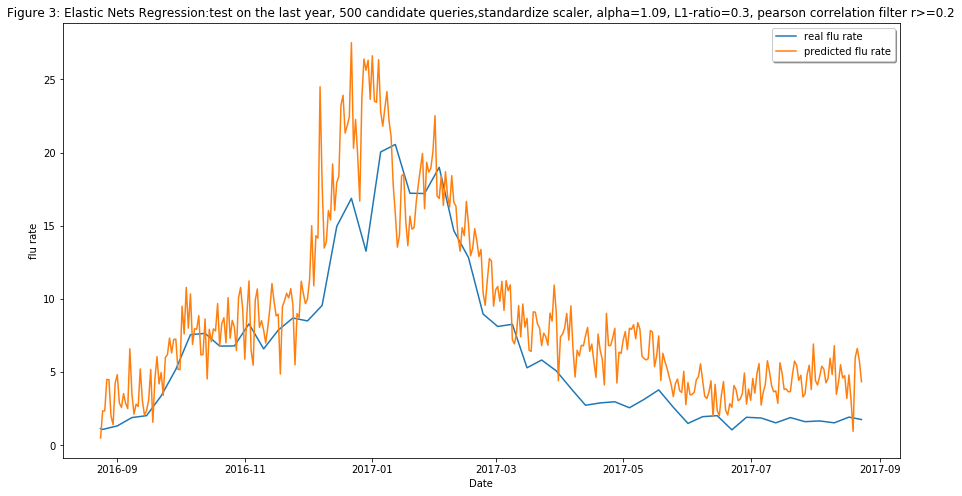

In [28]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 3: Elastic Nets Regression:test on the last year, 500 candidate queries,standardize scaler, alpha=1.09, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [29]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [30]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [31]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  222


para = range(1,100)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

In [32]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 222) (360, 222)


((3653, 222), (3653, 1))

In [21]:
para = np.arange(0.01, 3.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.1, 303 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 160 from 222
Best RMSE is updated! 
The mean absolute error is:  4.953209803953823
The root mean squared error is:  11.039628799760633
The correlation is:  0.3556028703165766
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 126 from 222
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 105 from 222
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 98 from 222
alpha: 0.05  L1-ratio: 0.3
Nonzero weights: 83 from 222
alpha: 0.060000000000000005  L1-ratio: 0.3
Nonzero weights: 80 from 222
alpha: 0.06999999999999999  L1-ratio: 0.3
Nonzero weights: 75 from 222
alpha: 0.08  L1-ratio: 0.3
Nonzero weights: 70 from 222
alpha: 0.09  L1-ratio: 0.3
Nonzero weights: 64 from 222
alpha: 0.09999999999999999  L1-ratio: 0.3
Nonzero weights: 60 from 222
alpha: 0.11  L1-ratio: 0.3
Nonzero weights: 57 from 222
alpha: 0.12  L1-ratio: 0.3
Nonzero weights: 57 from 222
alpha: 0.13  L1-rat

Nonzero weights: 17 from 222
Best RMSE is updated! 
The mean absolute error is:  6.964038858460862
The root mean squared error is:  10.709730791153786
The correlation is:  0.1149477934158317
----------------------------------------
alpha: 1.23  L1-ratio: 0.3
Nonzero weights: 17 from 222
Best RMSE is updated! 
The mean absolute error is:  6.964407976450153
The root mean squared error is:  10.680927328778406
The correlation is:  0.11479066909192727
----------------------------------------
alpha: 1.24  L1-ratio: 0.3
Nonzero weights: 17 from 222
Best RMSE is updated! 
The mean absolute error is:  6.964754768506923
The root mean squared error is:  10.652248509750548
The correlation is:  0.1146329238670385
----------------------------------------
alpha: 1.25  L1-ratio: 0.3
Nonzero weights: 17 from 222
Best RMSE is updated! 
The mean absolute error is:  6.965005548752656
The root mean squared error is:  10.623406986668355
The correlation is:  0.11447990634750348
------------------------------

Nonzero weights: 14 from 222
Best RMSE is updated! 
The mean absolute error is:  6.898365584639251
The root mean squared error is:  9.79908172189291
The correlation is:  0.11088771850905971
----------------------------------------
alpha: 1.52  L1-ratio: 0.3
Nonzero weights: 14 from 222
Best RMSE is updated! 
The mean absolute error is:  6.8949051951491205
The root mean squared error is:  9.768756629270056
The correlation is:  0.11074414061435943
----------------------------------------
alpha: 1.53  L1-ratio: 0.3
Nonzero weights: 13 from 222
Best RMSE is updated! 
The mean absolute error is:  6.8913982729704495
The root mean squared error is:  9.738594096077966
The correlation is:  0.1106036047726972
----------------------------------------
alpha: 1.54  L1-ratio: 0.3
Nonzero weights: 12 from 222
Best RMSE is updated! 
The mean absolute error is:  6.887914707863607
The root mean squared error is:  9.708543316236202
The correlation is:  0.11045639387007278
--------------------------------

Nonzero weights: 10 from 222
Best RMSE is updated! 
The mean absolute error is:  6.790806751858554
The root mean squared error is:  8.964594693812206
The correlation is:  0.10386482629839727
----------------------------------------
alpha: 1.86  L1-ratio: 0.3
Nonzero weights: 10 from 222
Best RMSE is updated! 
The mean absolute error is:  6.787761716286465
The root mean squared error is:  8.945142676731296
The correlation is:  0.10358582316307499
----------------------------------------
alpha: 1.87  L1-ratio: 0.3
Nonzero weights: 10 from 222
Best RMSE is updated! 
The mean absolute error is:  6.784715639614668
The root mean squared error is:  8.925942464441444
The correlation is:  0.10330167851371122
----------------------------------------
alpha: 1.8800000000000001  L1-ratio: 0.3
Nonzero weights: 10 from 222
Best RMSE is updated! 
The mean absolute error is:  6.781668575998556
The root mean squared error is:  8.9069944207387
The correlation is:  0.10301221366672894
--------------------

Nonzero weights: 7 from 222
Best RMSE is updated! 
The mean absolute error is:  6.688494114226081
The root mean squared error is:  8.469697030134546
The correlation is:  0.09573908119458167
----------------------------------------
alpha: 2.1599999999999997  L1-ratio: 0.3
Nonzero weights: 7 from 222
Best RMSE is updated! 
The mean absolute error is:  6.6842313590165405
The root mean squared error is:  8.455550429874839
The correlation is:  0.09560415974140281
----------------------------------------
alpha: 2.17  L1-ratio: 0.3
Nonzero weights: 7 from 222
Best RMSE is updated! 
The mean absolute error is:  6.679970148355647
The root mean squared error is:  8.44171501992941
The correlation is:  0.09546525781331561
----------------------------------------
alpha: 2.1799999999999997  L1-ratio: 0.3
Nonzero weights: 7 from 222
Best RMSE is updated! 
The mean absolute error is:  6.675712292884581
The root mean squared error is:  8.428194838269473
The correlation is:  0.09532219303379043
--------

Best RMSE is updated! 
The mean absolute error is:  6.530698494732319
The root mean squared error is:  8.150730218274662
The correlation is:  0.0984303934743274
----------------------------------------
alpha: 2.4499999999999997  L1-ratio: 0.3
Nonzero weights: 5 from 222
Best RMSE is updated! 
The mean absolute error is:  6.525309899926527
The root mean squared error is:  8.144728966952341
The correlation is:  0.09864101597870052
----------------------------------------
alpha: 2.46  L1-ratio: 0.3
Nonzero weights: 5 from 222
Best RMSE is updated! 
The mean absolute error is:  6.519933468948864
The root mean squared error is:  8.139062466929069
The correlation is:  0.09886804387309187
----------------------------------------
alpha: 2.4699999999999998  L1-ratio: 0.3
Nonzero weights: 5 from 222
Best RMSE is updated! 
The mean absolute error is:  6.514569079023504
The root mean squared error is:  8.13372906007315
The correlation is:  0.09911342335447546
--------------------------------------

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [22]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [2.63]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 222 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 222 features are selected
alpha: 2.63  L1-ratio: 0.3
Nonzero weights: 1 from 222
Best RMSE is updated! 
The mean absolute error is:  6.0163440214423884
The root mean squared error is:  7.203160307475683
The correlation is:  0.8780213323160667
----------------------------------------


In [33]:
enet = ElasticNet(alpha=2.63, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train4_X,train4_y)

y_pred2 = enet.predict(test2_X1)

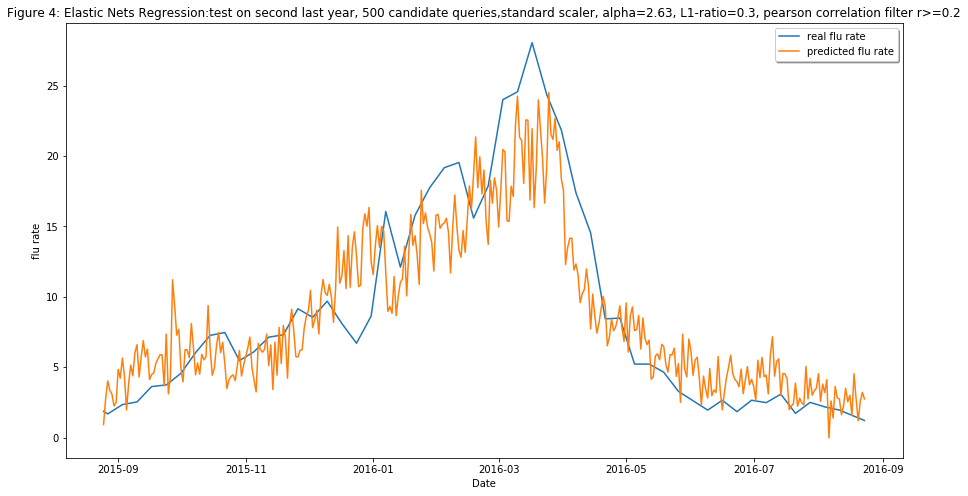

In [35]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 4: Elastic Nets Regression:test on second last year, 500 candidate queries,standard scaler, alpha=2.63, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()